# VGG and Gender

In [1]:
name = 'vgg_gender'

In [2]:
# Import needed libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import utilities
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [3]:
# Check Tensorflow version
print('Tensorflow version: ',tf.__version__)
# Check if GPU is being used
print('GPU available: ', tf.config.list_physical_devices('GPU'))
# If a GPU is being used, check that it's not being used by another process as well
if tf.config.list_physical_devices('GPU'):
  print("GPU usage: ", tf.config.experimental.get_memory_info('GPU:0'))

Tensorflow version:  2.10.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU usage:  {'current': 0, 'peak': 0}


## Load the data

In [4]:
def process_image(path_gender, label):
    # Desired size
    size = 250
    path, gender = path_gender
    # Get the image
    img = tf.io.read_file(path)
    # Decode the PNG
    img = tf.image.decode_png(img)
    # Resize image
    img = tf.image.resize(img, (size, size))
    # Reshape image (this is not necessary but I do it so that I don't need to be modifying the shape in the input layer)
    img = tf.reshape(img, [size, size, 1])
    # Cast image to float32
    img = tf.cast(img, tf.float32)
    # Normalize image
    img = img/255.0

    return (img, gender), label

In [5]:
def get_data(csv_path, images_folder_path, id_col, label_col, gender_col):
    df = pd.read_csv(csv_path)
    paths = [images_folder_path + '/' + str(id) + '.png' for id in df[id_col].tolist()]
    labels = df[label_col].tolist()
    gender = [0 if (str(g)=="False" or str(g)=='FALSE') else 1 for g in df[gender_col].tolist()] # male 1, female 0
    return paths, labels, gender

In [6]:
# Dataset used
ds = 'original_r250p'

# INPUT PIPELINE
#------------------------
# Training set
# ------------------------
train_paths, train_labels, train_gender = get_data( csv_path='./data/pre_processed/training/train.csv',
                                                images_folder_path='./data/pre_processed/training/{}'.format(ds),
                                                id_col='id',
                                                label_col='boneage',
                                                gender_col='male')

train_dataset = tf.data.Dataset.from_tensor_slices(((train_paths,train_gender),train_labels)).map(process_image)
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(32)

#------------------------
#Validation set
# ------------------------
validation_paths, validation_labels, validation_gender = get_data(
                                                csv_path='./data/pre_processed/validation/validation.csv',
                                                images_folder_path='./data/pre_processed/validation/{}'.format(ds),
                                                id_col='Image ID',
                                                label_col='Bone Age (months)',
                                                gender_col='male')
validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_paths,validation_gender),validation_labels)).map(process_image).batch(32)

In [7]:
# for (img,gender), label in train_dataset:
#     print(gender)
#     break

## Instantiate the model

In [8]:
# Model for only images

input_img = Input(shape=train_dataset.element_spec[0][0].shape[1:])
x = Conv2D(8, (3,3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3), strides=2, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), strides=2, activation='relu', padding='same' )(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

x = Model(inputs=input_img,outputs=x)

In [9]:
# Gender branch
input_gender = Input(shape=(1,))
y = Dense(100, activation='relu')(input_gender)

# Concatenate the two layers
z = tf.keras.layers.concatenate([x.output, y])
z = Dense(100, activation='relu')(z)
z = Dense(100, activation='relu')(z)
z = Dense(1)(z)

model = Model(inputs=[x.input, input_gender], outputs=z)

In [10]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [11]:
# To make that the learning rate decreases
def schedule(epoch, lr):
    if epoch>=50:
        return 0.0001
    return 0.001
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

In [12]:
# Experiment tracking with tensorboard
import time
experiment_name = "{}_{}_{}".format(name,ds,int(time.time()))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(experiment_name))

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 250, 250, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

## Training ("fit") the model

In [14]:
# Fit the model
r = model.fit(train_dataset, validation_data = validation_dataset, epochs=50, callbacks=[scheduler, tensorboard])

Epoch 1/50
395/395 [==============================] - 62s 120ms/step - loss: 1576.9639 - root_mean_squared_error: 39.7110 - val_loss: 2294.2993 - val_root_mean_squared_error: 47.8988 - lr: 0.0010
Epoch 2/50
395/395 [==============================] - 52s 123ms/step - loss: 975.1426 - root_mean_squared_error: 31.2273 - val_loss: 839.6218 - val_root_mean_squared_error: 28.9762 - lr: 0.0010
Epoch 3/50
395/395 [==============================] - 52s 123ms/step - loss: 667.6617 - root_mean_squared_error: 25.8392 - val_loss: 895.7853 - val_root_mean_squared_error: 29.9297 - lr: 0.0010
Epoch 4/50
395/395 [==============================] - 52s 123ms/step - loss: 548.7211 - root_mean_squared_error: 23.4248 - val_loss: 506.9703 - val_root_mean_squared_error: 22.5160 - lr: 0.0010
Epoch 5/50
395/395 [==============================] - 52s 123ms/step - loss: 468.5044 - root_mean_squared_error: 21.6450 - val_loss: 435.7224 - val_root_mean_squared_error: 20.8740 - lr: 0.0010
Epoch 6/50
395/395 [========

## Save the model

In [15]:
# Let's now save our model to a file
model.save('./models/{}.h5'.format(experiment_name))

## Make predictions


In [16]:
p_test = model.predict(validation_dataset).reshape(-1)

45/45 [==============================] - 1s 26ms/step


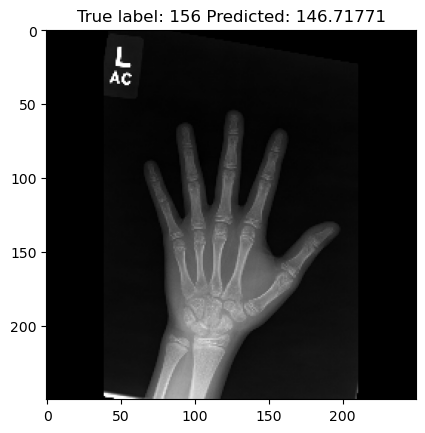

In [17]:
# Show some misclassified examples
y_test = np.array([label.numpy() for (img,gender), label in validation_dataset.unbatch()])
x_test = np.array([img.numpy() for (img,gender), label in validation_dataset.unbatch()])
difference = np.abs(np.subtract(y_test, p_test))
misclassified_idx = np.where(difference>4)
#print(len(misclassified_idx[0]))
i = np.random.choice(misclassified_idx[0])
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], p_test[i]));